# Train the StarNet Model

This notebook takes you through the steps of how to train a StarNet Model
- Required Python packages: `numpy h5py keras`
- Required data files: training_data.h5, mean_and_std.npy

Note: We use tensorflow for the keras backend.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import h5py
from numpy.random import seed

#the answer of every question 
# https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)
# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

from keras.models import Model
from keras.layers import Input, Dense, InputLayer, Flatten, Reshape, GRU,GlobalMaxPooling1D, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras.utils import HDF5Matrix

datadir = ""
training_set = datadir + '/content/drive/My Drive/TA/training_data_lower_snr.h5'
normalization_data = datadir + '/content/drive/My Drive/TA/starnet-master/mean_and_std.npy'

Using TensorFlow backend.


** Normalization **

Write a function to normalize the output labels. Each label will be normalized to have approximately have a mean of zero and unit variance.

NOTE: This is necessary to put output labels on a similar scale in order for the model to train properly, this process is reversed in the test stage to give the output labels their proper units

In [3]:
mean_and_std = np.load(normalization_data)
mean_labels = mean_and_std[0]
std_labels = mean_and_std[1]

def normalize(labels):
    # Normalize labels
    return (labels-mean_labels) / std_labels

** Obtain training data **

Here we will collect the output labels for the training and cross-validation sets, then normalize each.

Next we will create an HDF5Matrix for the training and cross-validation input spectra rather than loading them all into memory. This is useful to save RAM when training the model.

In [4]:
# Define the number of output labels
num_labels = np.load(datadir+'/content/drive/My Drive/TA/starnet-master/mean_and_std.npy').shape[1]

# Define the number of training spectra
num_train = 41000

# Load labels
with  h5py.File(training_set, 'r') as F:
    y_train = np.hstack((F['TEFF'][0:num_train], F['LOGG'][0:num_train], F['FE_H'][0:num_train]))
    y_cv = np.hstack((F['TEFF'][num_train:], F['LOGG'][num_train:], F['FE_H'][num_train:]))

# Normalize labels
y_train = normalize(y_train)
y_cv = normalize(y_cv)

# Create the spectra training and cv datasets
x_train = HDF5Matrix(training_set, 'spectrum', 
                           start=0, end=num_train)
x_cv = HDF5Matrix(training_set, 'spectrum', 
                           start=num_train, end=None)

# Define the number of output labels
num_labels = y_train.shape[1]

num_fluxes = x_train.shape[1]

print('Each spectrum contains ' + str(num_fluxes) + ' wavelength bins')
print('Training set includes ' + str(x_train.shape[0]) + 
      ' spectra and the cross-validation set includes ' + str(x_cv.shape[0])+' spectra')

Each spectrum contains 7214 wavelength bins
Training set includes 41000 spectra and the cross-validation set includes 3784 spectra


/usr/local/lib/python3.6/dist-packages/keras/utils/io_utils.py:60: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(datapath)


**Build the StarNet model architecture**

The StarNet architecture is built with:
- input layer
- 2 convolutional layers
- 1 maxpooling layer followed by flattening for the fully connected layer
- 2 fully connected layers
- output layer

First, let's define some model variables.

In [5]:
# activation function used following every layer except for the output layers
activation = 'relu'

# model weight initializer
initializer = 'he_normal'

# number of filters used in the convolutional layers
num_filters = [4,16]

# length of the filters in the convolutional layers
filter_length = 8

# length of the maxpooling window 
pool_length = 4

# number of nodes in each of the hidden fully connected layers
num_hidden = [256,128]

# number of spectra fed into model at once during training
batch_size = 64

# maximum number of interations for model training
max_epochs = 30

# initial learning rate for optimization algorithm
lr = 0.0007
    
# exponential decay rate for the 1st moment estimates for optimization algorithm
beta_1 = 0.9

# exponential decay rate for the 2nd moment estimates for optimization algorithm
beta_2 = 0.999

# a small constant for numerical stability for optimization algorithm
optimizer_epsilon = 1e-08

In [6]:
# Input spectra
input_spec = Input(shape=(num_fluxes,), name='starnet_input_x')

# Reshape spectra for CNN layers
cur_in = Reshape((num_fluxes, 1))(input_spec)

# CNN layers
cur_in = Conv1D(kernel_initializer=initializer, activation=activation, 
                padding="same", filters=num_filters[0], kernel_size=filter_length)(cur_in)
cur_in = Conv1D(kernel_initializer=initializer, activation=activation,
                padding="same", filters=num_filters[1], kernel_size=filter_length)(cur_in)

# Max pooling layer
cur_in = MaxPooling1D(pool_size=pool_length)(cur_in)

# Flatten the current input for the fully-connected layers
#cur_in = Flatten()(cur_in)
cur_in = GRU(128, return_sequences=True, activation="tanh", recurrent_activation="sigmoid", recurrent_dropout=0, 
              use_bias=True, unroll=False)(cur_in)#
cur_in = GlobalMaxPooling1D()(cur_in)
# Fully-connected layers
#cur_in = Dense(units=num_hidden[0], kernel_initializer=initializer, 
#               activation=activation)(cur_in)
#cur_in = Dense(units=num_hidden[1], kernel_initializer=initializer, 
#               activation=activation)(cur_in)

# Output nodes
output_label = Dense(units=num_labels, activation="linear", 
                     input_dim=num_hidden[1], name='starnet_output_y')(cur_in)

model = Model(input_spec, output_label, name='StarNet')

**More model techniques**
* The `Adam` optimizer is the gradient descent algorithm used for minimizing the loss function
* `EarlyStopping` uses the cross-validation set to test the model following every iteration and stops the training if the cv loss does not decrease by `min_delta` after `patience` iterations
* `ReduceLROnPlateau` is a form of learning rate decay where the learning rate is decreased by a factor of `factor` if the training loss does not decrease by `epsilon` after `patience` iterations unless the learning rate has reached `min_lr`

In [7]:
# Default loss function parameters
early_stopping_min_delta = 0.0001
early_stopping_patience = 4
reduce_lr_factor = 0.5
reuce_lr_epsilon = 0.0009
reduce_lr_patience = 2
reduce_lr_min = 0.00008

# loss function to minimize
loss_function = 'mean_squared_error'

# compute mean absolute deviation
metrics = ['mae']

In [8]:
optimizer = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=optimizer_epsilon, decay=0.0)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=early_stopping_min_delta, 
                                       patience=early_stopping_patience, verbose=2, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, epsilon=reuce_lr_epsilon, 
                                  patience=reduce_lr_patience, min_lr=reduce_lr_min, mode='min', verbose=2)

checkpoint_path =  '/content/drive/My Drive/TA/starnet-master/original/starnet_cnn_gru_ckpt-{epoch:02d}-{val_loss:.4f}.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


**Compile model**

In [9]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
model.summary()

Model: "StarNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
starnet_input_x (InputLayer) (None, 7214)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7214, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7214, 4)           36        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7214, 16)          528       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1803, 16)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1803, 128)         55680     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0   

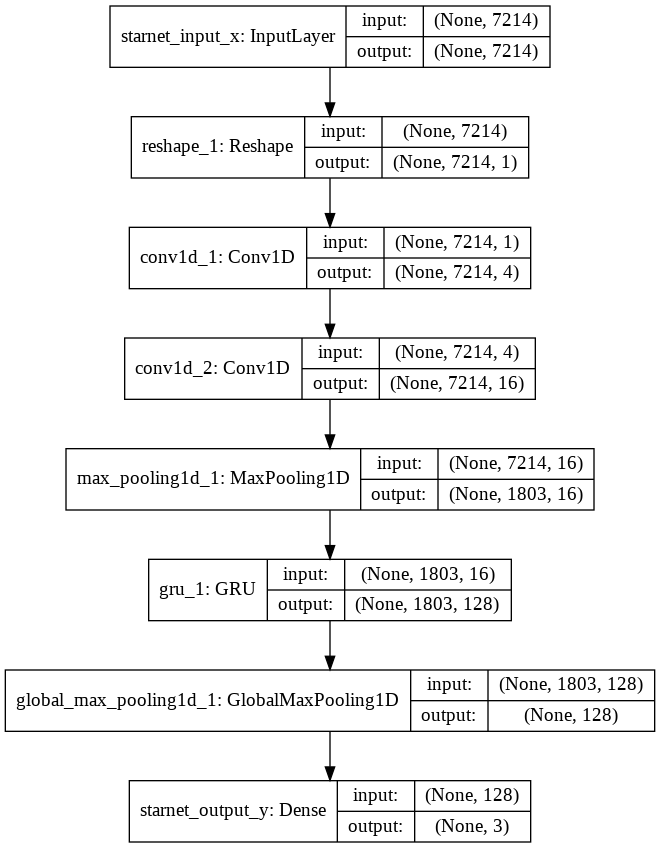

In [10]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [11]:
# Load partially trained model
from keras.models import load_model

model = load_model('/content/drive/My Drive/TA/starnet-master/original/starnet_cnn_gru_ckpt-06-0.0086.h5')

**Train model**

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_cv, y_cv),
          epochs=max_epochs, verbose=1, shuffle='batch', batch_size=64,
          callbacks=[early_stopping, reduce_lr, checkpoint])

Train on 41000 samples, validate on 3784 samples
Epoch 1/30
41000/41000 [==============================] - 3621s 88ms/step - loss: 0.0080 - mae: 0.0639 - val_loss: 0.0091 - val_mae: 0.0679

Epoch 00001: val_loss improved from inf to 0.00907, saving model to /content/drive/My Drive/TA/starnet-master/original/starnet_cnn_gru_ckpt-01-0.0091.h5
Epoch 2/30
41000/41000 [==============================] - 3571s 87ms/step - loss: 0.0078 - mae: 0.0631 - val_loss: 0.0079 - val_mae: 0.0641

Epoch 00002: val_loss improved from 0.00907 to 0.00790, saving model to /content/drive/My Drive/TA/starnet-master/original/starnet_cnn_gru_ckpt-02-0.0079.h5
Epoch 3/30
41000/41000 [==============================] - 3581s 87ms/step - loss: 0.0077 - mae: 0.0627 - val_loss: 0.0077 - val_mae: 0.0628

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00017499999376013875.

Epoch 00003: val_loss improved from 0.00790 to 0.00774, saving model to /content/drive/My Drive/TA/starnet-master/original/starnet_cnn_g

**Save model**

In [ ]:
starnet_model = '/content/drive/My Drive/TA/starnet-master/original/starnet_cnn_gru.h5'
model.save(datadir + starnet_model)
print(starnet_model+' saved.')

In [ ]:
import matplotlib.pyplot as plt

plt.grid()
plt.title('Training loss')
plt.plot(history.history['val_loss'], label ='Validation loss')
plt.plot(history.history['loss'], label = 'Loss')
plt.show()